![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [69]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [70]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [65]:
bikes.groupby('workingday').total.describe().T

workingday,0,1
count,3474.000000,7412.000000
mean,188.506621,193.011873
std,173.724015,184.513659
min,1.000000,1.000000
25%,44.000000,41.000000
50%,128.000000,151.000000
75%,304.000000,277.000000
max,783.000000,977.000000


In [66]:
import numpy as np
np.corrcoef(bikes.workingday, bikes.total)

array([[1.        , 0.01159387],
       [0.01159387, 1.        ]])

In [51]:
bikes.groupby('hour').total.describe().T

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,455.000000,454.000000,448.000000,433.000000,442.000000,452.000000,455.000000,455.000000,455.000000,455.000000,...,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,55.138462,33.859031,22.899554,11.757506,6.407240,19.767699,76.259341,213.116484,362.769231,221.780220,...,243.442982,254.298246,316.372807,468.765351,430.859649,315.278509,228.517544,173.370614,133.576754,89.508772
std,43.620012,34.112105,26.110267,12.666442,4.217633,12.784293,54.745333,159.207044,231.723065,92.099209,...,147.563199,144.235670,145.664786,223.775485,219.908138,156.641732,116.411565,87.629319,69.844495,51.638004
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,14.000000,...,12.000000,7.000000,11.000000,15.000000,23.000000,11.000000,11.000000,6.000000,9.000000,4.000000
25%,24.000000,11.000000,5.000000,3.000000,3.000000,8.000000,24.500000,63.000000,133.500000,161.000000,...,144.000000,154.000000,211.750000,277.000000,240.750000,190.000000,136.750000,103.500000,80.000000,52.750000
50%,41.000000,19.000000,11.000000,6.000000,6.000000,19.000000,75.000000,208.000000,392.000000,217.000000,...,212.000000,232.000000,309.500000,480.500000,422.500000,312.500000,224.000000,171.500000,129.000000,80.000000
75%,74.500000,46.000000,32.000000,15.000000,9.000000,29.000000,118.000000,334.000000,563.500000,294.500000,...,311.250000,331.000000,421.000000,608.500000,564.000000,416.000000,302.000000,230.000000,175.000000,123.000000
max,283.000000,168.000000,119.000000,66.000000,28.000000,57.000000,213.000000,596.000000,839.000000,414.000000,...,730.000000,724.000000,783.000000,970.000000,977.000000,743.000000,551.000000,584.000000,502.000000,256.000000


In [52]:
import numpy as np
np.corrcoef(bikes.hour, bikes.total)

array([[1.        , 0.40060119],
       [0.40060119, 1.        ]])

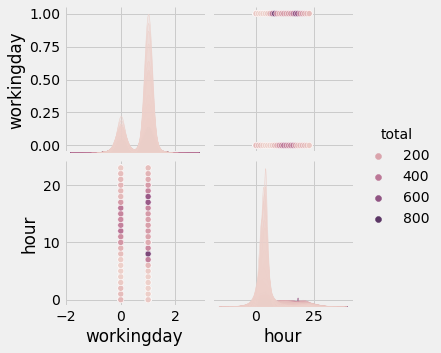

In [67]:
# Histogramas y Scatter Plots
import seaborn as sns

sns.pairplot(bikes.iloc[:,[2,10,11]], hue='total')

<AxesSubplot:xlabel='hour', ylabel='workingday'>

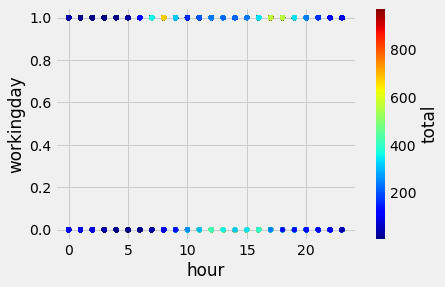

In [68]:
# Gráfica del workingday y hour
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
bikes.plot(kind='scatter', x='hour', y='workingday', c='total', colormap='jet')

### Análisis

- Para la variable "workingday", vemos que ~30% de las observaciones tienen valor 0 (días no laborables) y no hay mucha diferencia entre las rentas promedio en días laborables y no laborables. Esto se puede observar también en el coeficiente de correlación entre esta variable y la variable "total" (0.01)

- Para la variable "hour", vemos que las rentas promedio crecen a partir de las 7 de la mañana, llegando a un pico a las 6 de la tarde donde vuelve a bajar. Esto tiene sentido debido a las horas en las que las personas están descansando (antes de las 7 y por la noche). El coeficiente de correlación con la variable total es 0.4

- Lo interesante se produce cuando vemos ambas variables (workingday y hour), ya que se observa (por los gráficos usados) una diferencia de comportamiento en las rentas promedio durante el día, cuando es un día laborable (donde hay mayores rentas antes y después del horario de trabajo: 7 am y después de las 6 pm) vs un día no laborable donde las rentas suben en el día (entre 10 am y 6 pm).


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

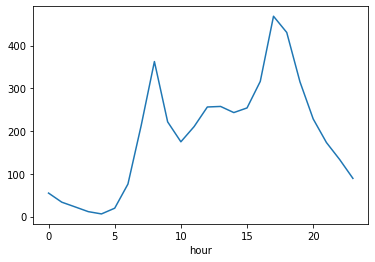

In [13]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

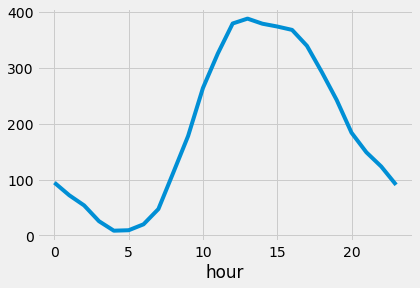

In [259]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
filtro1 = bikes['workingday']==0
bikes[filtro1].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

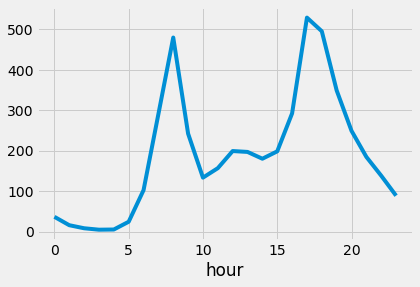

In [260]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
filtro2 = bikes['workingday']==1
bikes[filtro2].groupby('hour').total.mean().plot()

### Análisis

- Tal como lo observé en la pregunta anterior, en este caso se puede ver gráficamente: vemos en el gráfico de la celda 2.2 la evolución por hora de las rentas en un día no laborable y cómo tienen su pico durante el día (entre las 10 am y el final de la tarde), esto debido, obviamente, a que la gente no está trabajando. Por otro lado, en el gráfico de la celda 2.3 vemos la evolución por hora de las rentas en un día laborable y cómo tienen picos antes y después de la hora del trabajo (7 am y 7 pm).

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [158]:
# Celda 3
from sklearn.linear_model import LinearRegression

X=bikes.iloc[:,[2,11]]
y=bikes.total

#Partimos los datasets en Train y Test
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.33, random_state=0)


linmod=LinearRegression()
linmod.fit(XTrain,yTrain)

# Información del modelo
# ==============================================================================
print("Intercept:", linmod.intercept_)
print("Coeficiente:", list(zip(X.columns, linmod.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", linmod.score(X, y))


Intercept: 63.52695347088208
Coeficiente: [('workingday', 6.7704409951564655), ('hour', 10.550994216814978)]
Coeficiente de determinación R^2: 0.1604536219879903


In [159]:
# Error de test del modelo 
# ==============================================================================
from sklearn.metrics import mean_squared_error

predicciones = linmod.predict(X = XTest)

rmse = mean_squared_error(
        y_true  = yTest,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")


El error (rmse) de test es: 166.3052482486937


### Análisis

- Primero parto la muestra total en muestras de entrenamiento (67%) y evaluación (33%)
- Luego entreno el modelo de regresión lineal indicado, obteniendo los siguientes coeficientes e interpretaciones:
    - Intercepto: 63.5
    - Workingday: 6.8 -> no tiene interpretación o es más complicada debido a que es una variable categórica
    - Hour: 10.6 -> se puede interpretar que por cada hora que pasa del día aumentan las rentas en ~11
    
- En cuanto al desempeño del modelo, tenemos un R2 igual a 0.16 y un RMSE de 166.3, por lo cual no es un modelo que se ajuste correctamente a la muestra. Las limitaciones que tenemos es que son solo 2 variables y una de ellas es categórica. Probablemente si entrenamos dos modelos filtrando el workingday y usando solo la variable hour para predecir el total, tengamos mejores resultados (según lo observado en el análisis preliminar)

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [261]:
# Celda 4

#En este caso, al ser un árbol para regresión, utilizamos el mse para poder calibrar las particiones en las variables (y no el gini como en el caso de la clasificación)

def mse(y):
    error=0
    for i in range(len(y)):
        error+=((y[i]-y.mean())**2)/len(y)
    return error

def mse_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    
    mse_impurity_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    
    return mse_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = mse_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    #y_pred = int(y.mean() >= 0.5) 
    y_pred = y.mean() #El valor de la predicción es la media para el caso del árbol de regresión
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree



In [262]:
#Aplicamos el árbol con max_depth=6
tree = tree_grow(XTrain, yTrain, level=0, min_gain=0.001, max_depth=6, num_pct=10)

In [263]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [264]:
# Ejecución de función tree_predict
prediccion= tree_predict(XTest, tree)

In [265]:
# Cálculo del error

error=0
for i in range(0,len(yTest)):
    error+=((yTest[i]-prediccion[i])**2)/len(yTest)
        
print('El error de clasificación en la muestra de test es:')
print(error)

El error de clasificación en la muestra de test es:
11640.983524229769


### Conclusiones

- Luego de programar manualmente el árbol para la regresión sobre la muestra de entrenamiento y obtener las predicciones sobre la muestra de test, se obtiene un error igual a 11640.98

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

In [319]:
# Celda 5

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
rmse_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    rmse_scores.append(cross_val_score(clf, XTrain, yTrain, cv=10, scoring='neg_mean_squared_error').mean())


Text(0, 0.5, 'neg_mean_squared_error')

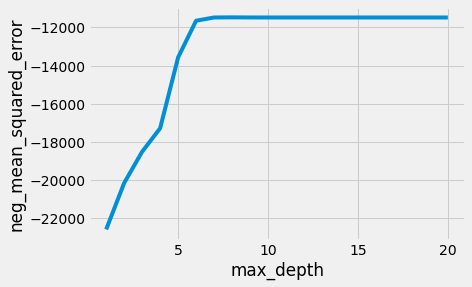

In [320]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, rmse_scores)
plt.xlabel('max_depth')
plt.ylabel('neg_mean_squared_error')

In [321]:
# Mejor mse (desempeño del modelo) y su correspondiente max_depth
sorted(zip(rmse_scores, max_depth_range))[::-1][0]

(-11469.028942365456, 8)

In [322]:
# max_depth=8 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeRegressor(max_depth=8, random_state=1)
clf.fit(XTrain, yTrain)

DecisionTreeRegressor(max_depth=8, random_state=1)

In [323]:
y_pred=clf.predict(XTest)

error=0
for i in range(0,len(yTest)):
    error+=((yTest[i]-y_pred[i])**2)/len(yTest)
        
print('El error de regresión en la muestra de test es:')
print(error)


El error de regresión en la muestra de test es:
11421.135771224664


### Análisis

- Luego de entrenar un árbol de decisión de regresión, calibrando el max_depth obteniendo 8 como óptimo en desempeño, y luego probar el modelo sobre la muestra de test, se obtiene un error de 11421.14, el cual es menor al obtenido en el árbol manual, es decir, se ajusta mejor. Sin embargo, si en el árbol de la librería usamos como mx_depth=6 (igual que en la corrida del árbol manual, el MSE sale muy parecido, por lo que parece ser que ambos modelos performan igual, a menos que se calibre un parámetro como la máxima profundidad)


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [273]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [274]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [275]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

Text(0, 0.5, 'Accuracy')

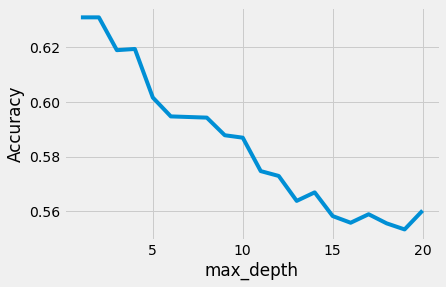

In [290]:
# Celda 6

#DT

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del accuracy para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

# Gráfica max_depth versus accuracy
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')


In [291]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6308888888888888, 2)

In [292]:
# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

In [293]:
prediccionTree=clf.predict(X_test)
metrics.f1_score(prediccionTree, y_test), metrics.accuracy_score(prediccionTree, y_test)

(0.6448598130841121, 0.6453333333333333)

In [294]:
# RL

from sklearn.linear_model import LogisticRegression

clfRegLog= LogisticRegression(random_state=0,max_iter=10000)
clfRegLog.fit(X_train, y_train)

prediccionesRegLog=clfRegLog.predict(X_test)
prediccionesProbRegLog=clfRegLog.predict_proba(X_test)


In [295]:
metrics.f1_score(prediccionesRegLog, y_test), metrics.accuracy_score(prediccionesRegLog, y_test)

(0.6074380165289257, 0.62)

### Análisis

- Entrenamos ambos modelos sobre el set de entrenamiento. En el árbol de decisión calibramos el parámetro max_depth obteniendo como punto óptimo el valor de 2. Los resultados del desempeño sobre la muestra de evaluación son los siguientes:

    - DT: F1_score= 0.6448, accuracy= 0.6453
    - RL: F1_score= 0.6074, accuracy= 0.62
    
- En conclusión, el árbol de decisión calibrado obtiene mejor desempeño sobre la muestra de evaluación-

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [296]:
# Celda 7

# Ejercicio 1: 100 árboles de decisión donde max_depth = None

# Definición del modelo BaggingClassifier de la libreria sklearn
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [297]:
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6567567567567568, 0.6613333333333333)

In [298]:
# Ejercicio 2: 100 árboles de decisión donde max_depth = 2

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [299]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.631578947368421, 0.6453333333333333)

In [326]:
# Ejercicio 3: 100 regresiones logísticas

clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [327]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6124661246612466, 0.6186666666666667)

### Análisis

- Finalmente observamos que el mejor desempeño se da en el ensamble de 100 árboles de decisión donde max_depth = None, con las suguientes métricas de desempeño:
    - F1_score = 0.6567
    - Accuracy = 0.6613

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [302]:
# Celda 8

# Ejercicio 1: 100 árboles de decisión donde max_depth = None

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)


In [303]:
# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6567567567567568, 0.6613333333333333)

In [304]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [305]:
# Desempeño al hacer votación ponderada
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6631087391594397, 0.6633333333333333)

In [310]:
# Ejercicio 2: 100 árboles de decisión donde max_depth = 2

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [311]:
# Predicción y desempeño al hacer votación mayoritaria

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.631578947368421, 0.6453333333333333)

In [312]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [313]:
# Desempeño al hacer votación ponderada
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6324549237170597, 0.6466666666666666)

In [314]:
# Ejercicio 3: 100 regresiones logísticas

clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [315]:
# Predicción y desempeño al hacer votación mayoritaria

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6124661246612466, 0.6186666666666667)

In [316]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [317]:
# Desempeño al hacer votación ponderada
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

(0.6153846153846154, 0.62)

### Análisis

- Finalmente observamos que el mejor desempeño se da en el ensamble de 100 árboles de decisión donde max_depth = None, con las suguientes métricas de desempeño:
    - F1_score = 0.6631
    - Accuracy = 0.6633

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

#### Celda 9

- Podemos observar que tanto en la metodología del punto 7 (votación mayoritaria) como en la metodología del punto 8 (votación ponderada) el escenario que presenta un mejor desempeño es el ensamble de árboles de decisión con parámetro max_depth nulo (con accuracy de 0.6613 y 0.6633 respectivamente).

- También se observa que en los 3 escenarios se mejora un poco el accuracy al usar la metodología de votación ponderada (sobre la de votación mayoritaria). Esc 1 ( 0.6633 vs 0.6613), Esc 2 (0.6466 vs 0.6453). Esc 3 (0.62 vs 0.6186). Sin embargo, no es una mejora significativa, por lo que podría considerarse usar cualquier metodología (la mayoritaria podría ser más simple).

- A nivel de los ensamblajes el árbol de decisión además de poseer un mejor desempeño en el accuracy, tiene la ventaja de ser muy interpretable y admitir tanto variables categóricas como numéricas.

